# XOR RXOR BTE Experiment with CPD registration

In [1]:
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
import numpy as np
import pickle
from joblib import Parallel, delayed
from math import log2, ceil

In [2]:
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from proglearn.sims import generate_gaussian_parity
from pycpd import AffineRegistration

Using TensorFlow backend.


## Registration Function

In [3]:
def cpd_reg(template, target, max_iter=50):    
    registration = AffineRegistration(X=target, Y=template, max_iterations=max_iter)
    deformed_template = registration.register(template)
    
    return deformed_template[0]

## Simulation Data Generation


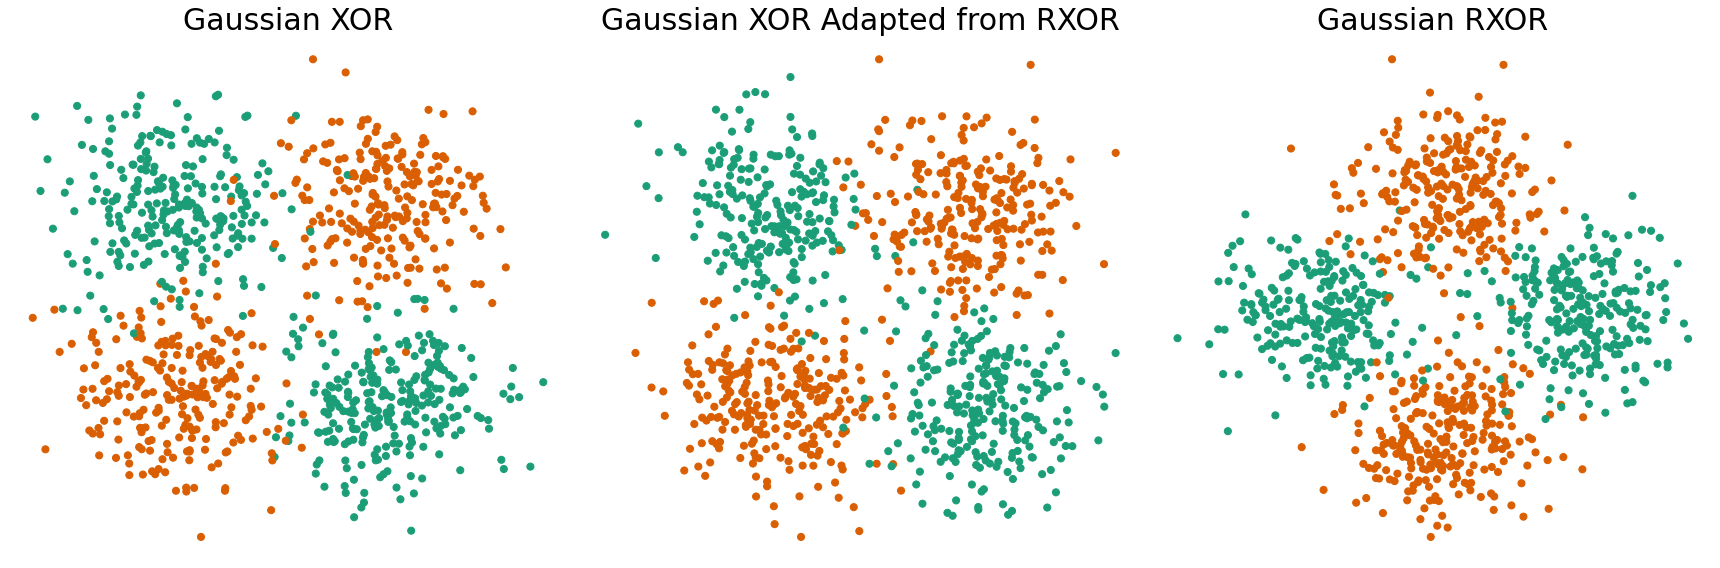

In [4]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi/4)
X_axor, y_axor = cpd_reg(X_rxor.copy(), X_xor.copy(), max_iter=50), y_rxor.copy()

colors = sns.color_palette('Dark2', n_colors=2)

fig, ax = plt.subplots(1,3, figsize=(24,8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Gaussian XOR', fontsize=30)
ax[0].axis('off')

clr = [colors[i] for i in y_axor]
ax[1].scatter(X_axor[:, 0], X_axor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Gaussian XOR Adapted from RXOR', fontsize=30)
ax[1].axis('off')

clr = [colors[i] for i in y_rxor]
ax[2].scatter(X_rxor[:, 0], X_rxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title('Gaussian RXOR', fontsize=30)
ax[2].axis('off')

plt.tight_layout()

## Experiment definition

In [5]:
def experiment(n_task1, n_task2, n_test=1000, 
               task1_angle=0, task2_angle=np.pi/2, 
               n_trees=10, max_depth=None, random_state=None,
               register=False):
    
    """
    A function to do backwards transfer efficiency experiment 
    between two tasks. Task 1 is XOR. Task 2 is RXOR. 
    A registered Task 2
    
    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.
    
    n_task2 : int
        Total number of train dsample for task 2

    n_test : int, optional (default=1000)
        Number of test sample for each task.
        
    task1_angle : float, optional (default=0)
        Angle in radian for task 1.
            
    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.
            
    n_trees : int, optional (default=10)
        Number of total trees to train for each task.

    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.
        
    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        
    register: boolean, default=False
        Register task2 to task1 before feeding to forest.
    
    Returns
    -------
    errors : array of shape [6]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2, naive UF error task1,
        naive UF task2.
    """

    if n_task1==0 and n_task2==0:
        raise ValueError('Wake up and provide samples to train!!!')

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6,dtype=float)

    default_transformer_class = TreeClassificationTransformer
    default_transformer_kwargs = {"kwargs" : {"max_depth" : max_depth}}

    default_voter_class = TreeClassificationVoter
    default_voter_kwargs = {}

    default_decider_class = SimpleArgmaxAverage
    default_decider_kwargs = {"classes" : np.arange(2)}
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    naive_uf = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                            default_transformer_kwargs = default_transformer_kwargs,
                                            default_voter_class = default_voter_class,
                                            default_voter_kwargs = default_voter_kwargs,
                                            default_decider_class = default_decider_class,
                                            default_decider_kwargs = default_decider_kwargs)
    
    #source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(n_test, angle_params=task1_angle)

    #target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(n_test, angle_params=task2_angle)
        

    if register:
        X_task2 = cpd_reg(X_task2.copy(), X_task1.copy())
            
    progressive_learner.add_task(X_task1, y_task1, num_transformers=n_trees)
    progressive_learner.add_task(X_task2, y_task2, num_transformers=n_trees)

    uf.add_task(X_task1, y_task1, num_transformers=2*n_trees)
    uf.add_task(X_task2, y_task2, num_transformers=2*n_trees)
        
    uf_task1=uf.predict(test_task1, transformer_ids=[0], task_id=0)
    l2f_task1=progressive_learner.predict(test_task1, task_id=0)

    errors[0] = 1 - np.mean(
        uf_task1 == test_label_task1
    )
    errors[1] = 1 - np.mean(
        l2f_task1 == test_label_task1
    )

    return errors


## Experiment for Backward Transfer Efficiency (BTE) vs. angle of rotation for the second task

In [6]:
###main hyperparameters###
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 1000

mean_te1 = np.zeros(len(angle_sweep), dtype=float)
for ii,angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            task1_sample,task2_sample,
            task2_angle=angle*np.pi/180, 
            max_depth=ceil(log2(task1_sample)),
            register=False
        ) for _ in range(mc_rep)
      )
    )

    mean_te1[ii] = np.mean(error[:,0])/np.mean(error[:,1])

with open('mean_angle_te1.pickle','wb') as f:
    pickle.dump(mean_te1,f)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   19.6s
[Paral

In [7]:
###main hyperparameters###
angle_sweep = range(0,91,10)
task1_sample = 100
task2_sample = 100
mc_rep = 1000

mean_te2 = np.zeros(len(angle_sweep), dtype=float)
for ii,angle in enumerate(angle_sweep):
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
        delayed(experiment)(
            task1_sample,task2_sample,
            task2_angle=angle*np.pi/180, 
            max_depth=ceil(log2(task1_sample)),
            register=True
        ) for _ in range(mc_rep)
      )
    )

    mean_te2[ii] = np.mean(error[:,0])/np.mean(error[:,1])

with open('mean_angle_te2.pickle','wb') as g:
    pickle.dump(mean_te2,g)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   22.3s
[Paral

## Plot the result

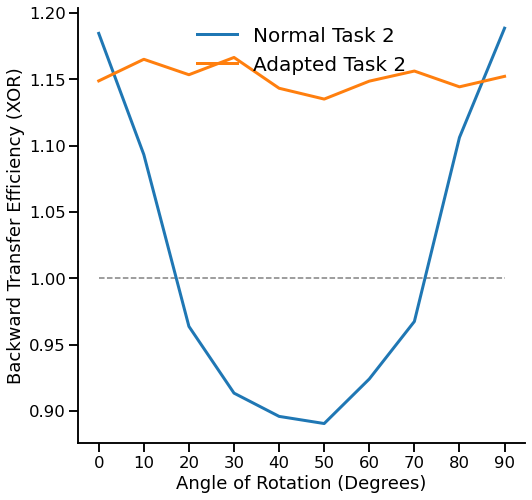

In [8]:
with open('mean_angle_te1.pickle','rb') as f:
    te1 = pickle.load(f)
with open('mean_angle_te2.pickle','rb') as g:
    te2 = pickle.load(g)
    
angle_sweep = range(0,91,10)

sns.set_context("talk")
fig, ax = plt.subplots(1,1, figsize=(8,8))
task = ['Normal Task 2', 'Adapted Task 2']
ax.plot(angle_sweep,te1,linewidth = 3, label=task[0])
ax.plot(angle_sweep,te2,linewidth = 3, label=task[1])
ax.set_xticks(range(0,91,10))
ax.set_xlabel('Angle of Rotation (Degrees)')
ax.set_ylabel('Backward Transfer Efficiency (XOR)')
ax.hlines(1, 0,90, colors='gray', linestyles='dashed',linewidth=1.5)
ax.legend(loc='upper center', fontsize=20, frameon=False)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
